In [ ]:
pip install transformers

In [ ]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFXLMRobertaForSequenceClassification
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load your dataset
df = pd.read_csv("/content/drive/MyDrive/tamil_sentiment")

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
max_length = 512
batch_size = 6

# Instantiate the tokenizer
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
# Assuming you have four labels: 0, 1, 2, 3
num_labels = 4

def convert_example_to_feature(sentiment):
    return tokenizer.encode_plus(sentiment,
                                 add_special_tokens=True,
                                 max_length=max_length,
                                 padding='max_length',
                                 return_attention_mask=True,
                                 truncation=True
                                 )

In [ ]:
def map_example_to_dict(row):
    xlm_roberta_input = convert_example_to_feature(row['tamil_cleaned'])
    return {
        "input_ids": xlm_roberta_input['input_ids'],
        "attention_mask": xlm_roberta_input['attention_mask'],
    }, tf.keras.utils.to_categorical(row['label'], num_classes=num_labels)

In [ ]:
def encode_examples(df, limit=-1):
    if limit > 0:
        df = df.head(limit)

    input_ids_list = []
    attention_mask_list = []
    label_list = []

    for _, row in df.iterrows():
        example_dict, label = map_example_to_dict(row)
        input_ids_list.append(example_dict['input_ids'])
        attention_mask_list.append(example_dict['attention_mask'])
        label_list.append(label)

    return (
        tf.convert_to_tensor(input_ids_list),
        tf.convert_to_tensor(attention_mask_list),
        tf.convert_to_tensor(label_list)
    )

In [ ]:
# Encode the dataset
train_dataset = encode_examples(train)
test_dataset = encode_examples(test)

In [ ]:
# Model initialization
model_name = 'xlm-roberta-base'  # Replace with your desired model
model = TFXLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFXLMRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFXLMRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Choosing Adam optimizer
learning_rate = 2e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# Loss function: Categorical Crossentropy
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
# Assuming you have the train_dataset from the previous code
input_ids, attention_mask, labels = train_dataset

# Assuming you have the test_dataset from the previous code
val_input_ids, val_attention_mask, val_labels = test_dataset

In [ ]:
checkpoint_path = "xlm_roberta_training_checkpoint.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=2
)

In [ ]:
# Train the model
history = model.fit(
    x={'input_ids': input_ids, 'attention_mask': attention_mask},
    y=labels,
    epochs=2,
    batch_size=batch_size,
    validation_data=(
        {'input_ids': val_input_ids, 'attention_mask': val_attention_mask},
        val_labels.numpy()
    ),
    callbacks=[checkpoint_callback]
)

Epoch 1/2
5028/5028 [==============================] - ETA: 0s - loss: 1.1212 - accuracy: 0.5929
Epoch 1: val_loss improved from inf to 1.13048, saving model to xlm_roberta_training_checkpoint.ckpt
5028/5028 [==============================] - 4092s 804ms/step - loss: 1.1212 - accuracy: 0.5929 - val_loss: 1.1305 - val_accuracy: 0.5849
Epoch 2/2
5028/5028 [==============================] - ETA: 0s - loss: 1.0681 - accuracy: 0.5934
Epoch 2: val_loss improved from 1.13048 to 1.01237, saving model to xlm_roberta_training_checkpoint.ckpt
5028/5028 [==============================] - 4026s 801ms/step - loss: 1.0681 - accuracy: 0.5934 - val_loss: 1.0124 - val_accuracy: 0.5849


In [ ]:
# At some point, you decide to pause training and save the model's current state
model.save_weights("/content/drive/MyDrive/roberta_model_saved_at_pause.ckpt")

In [ ]:
train_loss_history=[]
train_accuracy_history=[]
val_loss_history=[]
val_accuracy_history=[]

In [ ]:
# Store metrics in lists
train_loss_history.extend(history.history['loss'])
train_accuracy_history.extend(history.history['accuracy'])
val_loss_history.extend(history.history['val_loss'])
val_accuracy_history.extend(history.history['val_accuracy'])

In [ ]:
print("train_loss_history : ",train_loss_history)
print("train_accuracy_history : ",train_accuracy_history)
print("val_loss_history : ",val_loss_history)
print("val_accuracy_history : ",val_accuracy_history)

train_loss_history :  [1.1212393045425415, 1.0680525302886963]
train_accuracy_history :  [0.5929253697395325, 0.5933563113212585]
val_loss_history :  [1.1304782629013062, 1.0123660564422607]
val_accuracy_history :  [0.5849356651306152, 0.5849356651306152]


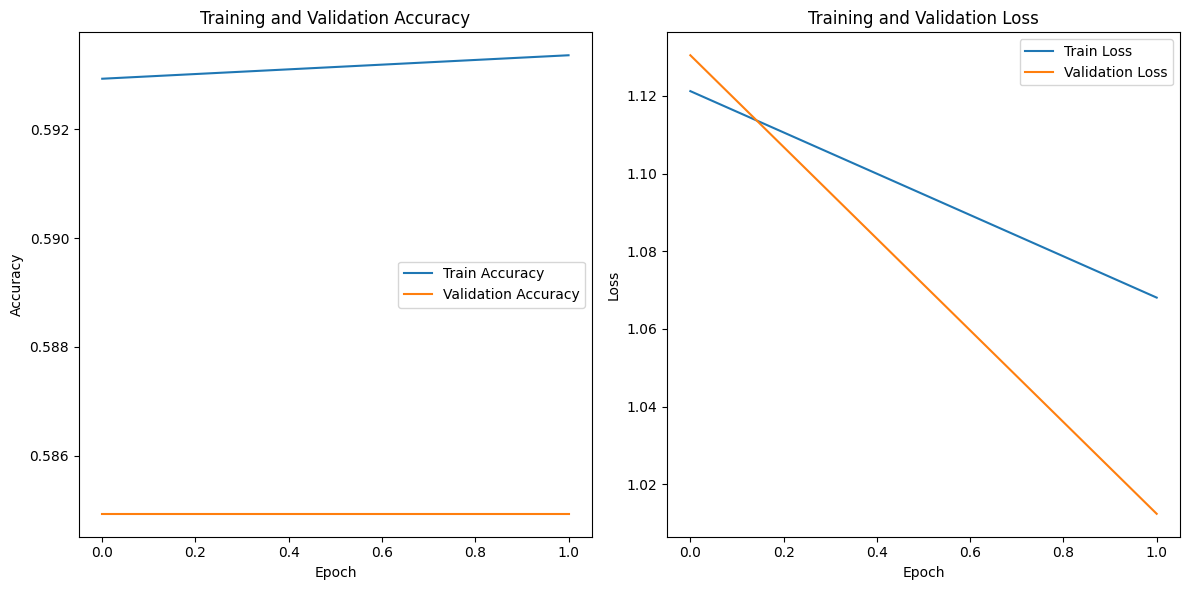

In [ ]:
#Plot training and validation accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
predictions = model.predict(
    x={'input_ids': val_input_ids, 'attention_mask': val_attention_mask}
)

236/236 [==============================] - 291s 1s/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay,roc_curve, auc,roc_auc_score
import numpy as np

In [ ]:
# Convert predictions to labels
predicted_labels = np.argmax(predictions.logits, axis=1)

# Convert one-hot encoded true labels to categorical labels
true_labels = np.argmax(val_labels.numpy(), axis=1)

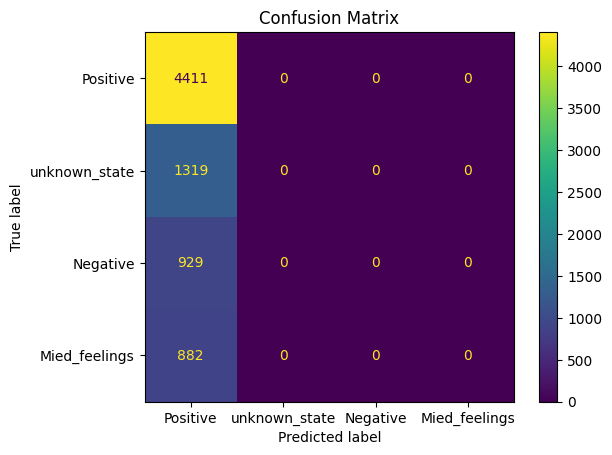

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Positive','unknown_state','Negative','Mied_feelings'])
disp.plot(cmap='viridis', values_format='d')

plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=['Positive','unknown_state','Negative','Mied_feelings'])
print(class_report)

               precision    recall  f1-score   support

     Positive       0.58      1.00      0.74      4411
unknown_state       0.00      0.00      0.00      1319
     Negative       0.00      0.00      0.00       929
Mied_feelings       0.00      0.00      0.00       882

     accuracy                           0.58      7541
    macro avg       0.15      0.25      0.18      7541
 weighted avg       0.34      0.58      0.43      7541



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Assuming predicted_labels and true_labels are NumPy arrays
data = {'Predicted_Labels': predicted_labels, 'True_Labels': true_labels}
try1 = pd.DataFrame(data)

# Save DataFrame to a CSV file
try1.to_csv('/content/drive/MyDrive/predicted_vs_true_labels1.csv', index=False)

In [ ]:
try1=pd.read_csv("/content/drive/MyDrive/predicted_vs_true_labels1.csv")

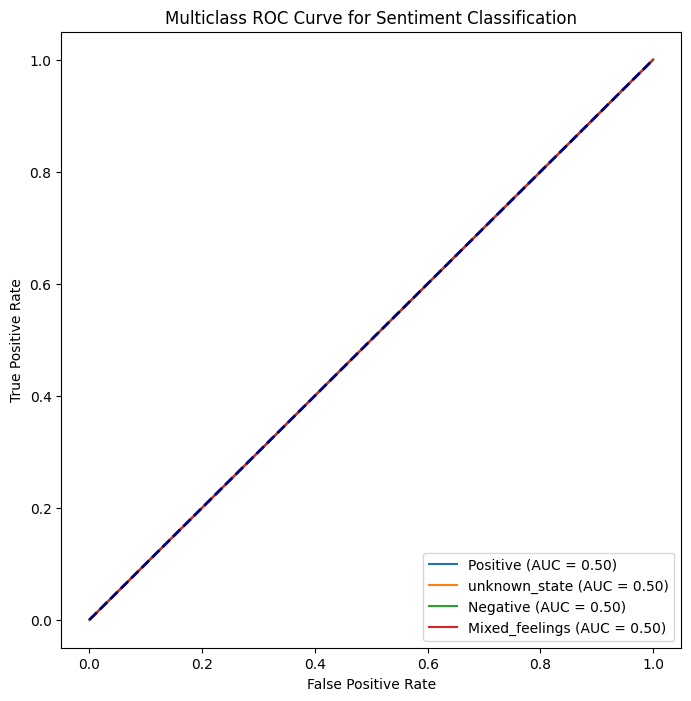

In [ ]:
# Assuming you have four labels
labels = ['Positive', 'unknown_state', 'Negative', 'Mixed_feelings']

# Calculate ROC-AUC score for each class
roc_auc_scores = []
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(try1["True_Labels"] == i, try1["Predicted_Labels"] == i)
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)

# Plot ROC curve for each class
plt.figure(figsize=(8, 8))
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(try1["True_Labels"] == i, try1["Predicted_Labels"] == i)
    plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve for Sentiment Classification')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Later, when you want to resume training, load the saved model state
model.load_weights("/content/drive/MyDrive/roberta_model_saved_at_pause.ckpt")

In [ ]:
# Train the model
history = model.fit(
    x={'input_ids': input_ids, 'attention_mask': attention_mask},
    y=labels,
    epochs=2,
    batch_size=batch_size,
    validation_data=(
        {'input_ids': val_input_ids, 'attention_mask': val_attention_mask},
        val_labels.numpy()
    ),
    callbacks=[checkpoint_callback]
)

Epoch 1/2
5028/5028 [==============================] - ETA: 0s - loss: 1.0666 - accuracy: 0.5950
Epoch 1: val_loss improved from inf to 1.00830, saving model to xlm_roberta_training_checkpoint.ckpt
5028/5028 [==============================] - 4408s 828ms/step - loss: 1.0666 - accuracy: 0.5950 - val_loss: 1.0083 - val_accuracy: 0.5945
Epoch 2/2
5028/5028 [==============================] - ETA: 0s - loss: 1.0382 - accuracy: 0.5956
Epoch 2: val_loss improved from 1.00830 to 1.00259, saving model to xlm_roberta_training_checkpoint.ckpt
5028/5028 [==============================] - 4160s 827ms/step - loss: 1.0382 - accuracy: 0.5956 - val_loss: 1.0026 - val_accuracy: 0.6039


In [ ]:
train_loss_history=[1.1212393045425415, 1.0680525302886963]
train_accuracy_history=[0.5929253697395325, 0.5933563113212585]
val_loss_history=[1.1304782629013062, 1.0123660564422607]
val_accuracy_history=[0.5849356651306152, 0.5849356651306152]

In [ ]:
# Store metrics in lists
train_loss_history.extend(history.history['loss'])
train_accuracy_history.extend(history.history['accuracy'])
val_loss_history.extend(history.history['val_loss'])
val_accuracy_history.extend(history.history['val_accuracy'])

In [ ]:
print("train_loss_history : ",train_loss_history)
print("train_accuracy_history : ",train_accuracy_history)
print("val_loss_history : ",val_loss_history)
print("val_accuracy_history : ",val_accuracy_history)

train_loss_history :  [1.1212393045425415, 1.0680525302886963, 1.0665572881698608, 1.0381770133972168]
train_accuracy_history :  [0.5929253697395325, 0.5933563113212585, 0.5950139164924622, 0.5955775380134583]
val_loss_history :  [1.1304782629013062, 1.0123660564422607, 1.0082981586456299, 1.002587080001831]
val_accuracy_history :  [0.5849356651306152, 0.5849356651306152, 0.594483494758606, 0.6038987040519714]


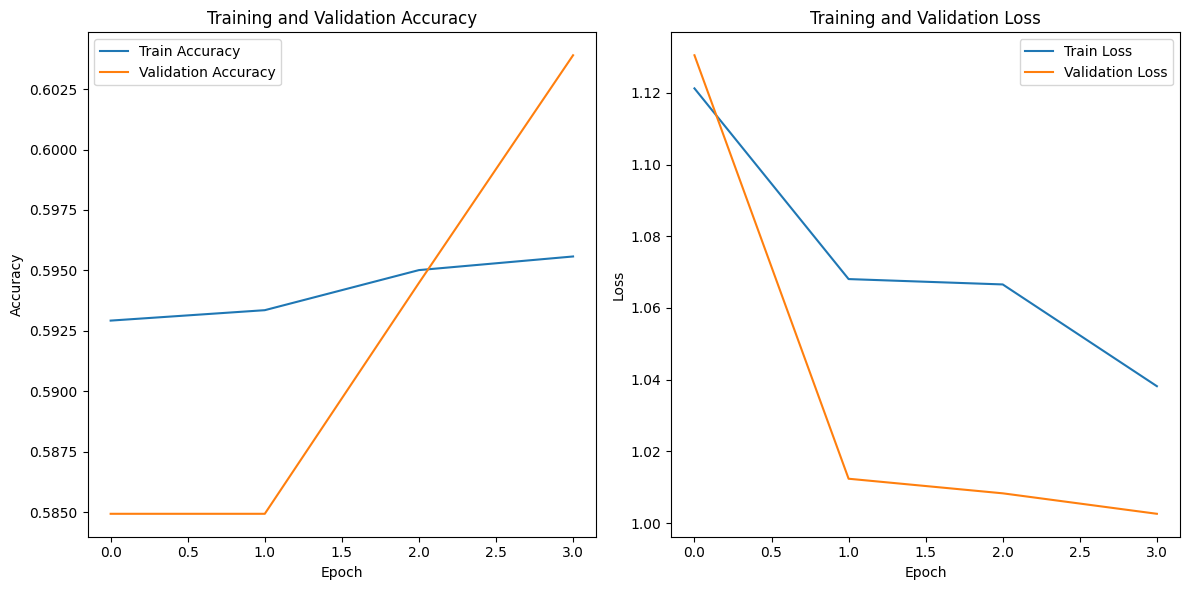

In [ ]:
#Plot training and validation accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
predictions = model.predict(
    x={'input_ids': val_input_ids, 'attention_mask': val_attention_mask}
)

236/236 [==============================] - 297s 1s/step


In [ ]:
import numpy as np

In [ ]:
# Convert predictions to labels
predicted_labels = np.argmax(predictions.logits, axis=1)

# Convert one-hot encoded true labels to categorical labels
true_labels = np.argmax(val_labels.numpy(), axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay,roc_curve, auc,roc_auc_score

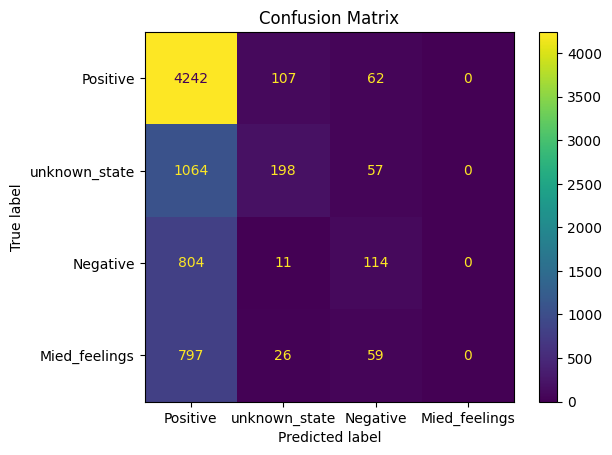

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Positive','unknown_state','Negative','Mied_feelings'])
disp.plot(cmap='viridis', values_format='d')

plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=['Positive','unknown_state','Negative','Mied_feelings'])
print(class_report)

               precision    recall  f1-score   support

     Positive       0.61      0.96      0.75      4411
unknown_state       0.58      0.15      0.24      1319
     Negative       0.39      0.12      0.19       929
Mied_feelings       0.00      0.00      0.00       882

     accuracy                           0.60      7541
    macro avg       0.40      0.31      0.29      7541
 weighted avg       0.51      0.60      0.50      7541



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


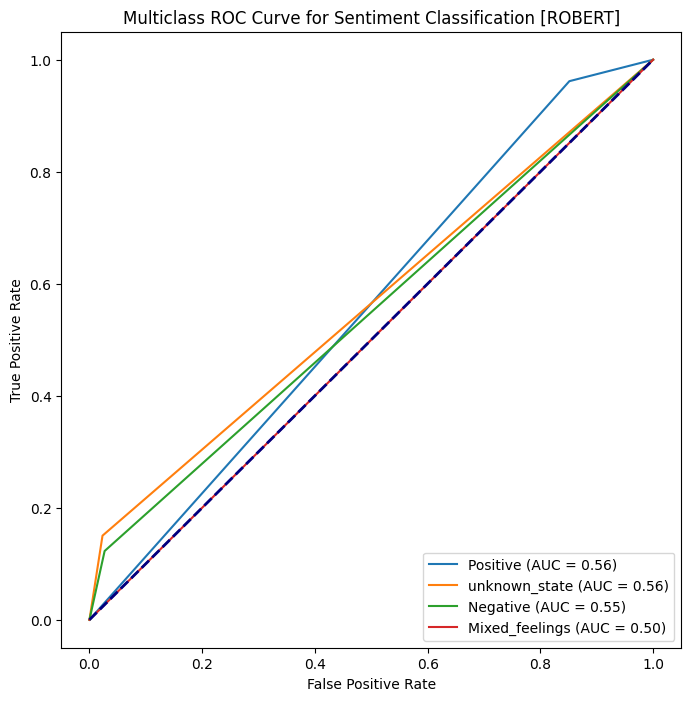

In [ ]:
# Assuming you have four labels
labels = ['Positive', 'unknown_state', 'Negative', 'Mixed_feelings']

# Calculate ROC-AUC score for each class
roc_auc_scores = []
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(true_labels == i,predicted_labels == i)
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)

# Plot ROC curve for each class
plt.figure(figsize=(8, 8))
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(true_labels == i,predicted_labels == i)
    plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve for Sentiment Classification [ROBERT]')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# At some point, you decide to pause training and save the model's current state
model.save_weights("/content/drive/MyDrive/roberta_model_saved_at_pause2.ckpt")